In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [7]:
df = pd.read_csv("Gender-Pay-Gap.csv")
df


,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319
...,...,...,...,...,...,...,...,...,...
995,Marketing Associate,Female,61,1,High School,Administration,1,62644,3270
996,Data Scientist,Male,57,1,Masters,Sales,2,108977,3567
997,Financial Analyst,Male,48,1,High School,Operations,1,92347,2724
998,Financial Analyst,Male,65,2,High School,Administration,1,97376,2225


In [8]:
# Check for missing values and drop rows with missing values (if any)
df = df.dropna()

# Remove duplicate rows
df = df.drop_duplicates()

# Ensure data types are correct (convert columns if necessary)
# For example, if 'Age' should be an integer, ensure it's correctly typed
df['Age'] = df['Age'].astype(int)

# Handle outliers (example: remove rows with BasePay or Bonus beyond a reasonable range)
df = df[(df['BasePay'] > 0) & (df['Bonus'] > 0)]

# Standardize column names (optional, e.g., make all lowercase)
df.columns = df.columns.str.lower()

# Display the cleaned dataset
df

,jobtitle,gender,age,perfeval,education,dept,seniority,basepay,bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319
...,...,...,...,...,...,...,...,...,...
995,Marketing Associate,Female,61,1,High School,Administration,1,62644,3270
996,Data Scientist,Male,57,1,Masters,Sales,2,108977,3567
997,Financial Analyst,Male,48,1,High School,Operations,1,92347,2724
998,Financial Analyst,Male,65,2,High School,Administration,1,97376,2225


### How do performance evaluation scores relate to overall compensation (base pay and bonus) for male versus female employees
This step aims to identify patterns or inconsistencies. It is followed by using multiple linear regression to assess whether performance ratings predict total compensation (bonus and base pay). Gender is included as a key factor, and an interaction term between gender and performance scores will examine whether this relationship differs for male and female employees. If unexpected patterns arise, alternative approaches may be considered. This method combines graphical and statistical techniques to analyze pay-performance links and fairness in compensation practices.


In [10]:
# Create a new column for total compensation (base pay + bonus)
df['total_compensation'] = df['basepay'] + df['bonus']

# Encode gender as a binary variable (e.g., 0 for male, 1 for female)
df['gender_encoded'] = df['gender'].map({'Male': 0, 'Female': 1})

# Fit a multiple linear regression model
# Include performance evaluation scores, gender, and an interaction term between gender and performance scores
formula = 'total_compensation ~  perfeval + gender_encoded + perfeval:gender_encoded'
model = smf.ols(formula=formula, data=df).fit()

# Display the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     total_compensation   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     9.893
Date:                Fri, 25 Apr 2025   Prob (F-statistic):           1.97e-06
Time:                        19:32:26   Log-Likelihood:                -11537.
No. Observations:                1000   AIC:                         2.308e+04
Df Residuals:                     996   BIC:                         2.310e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

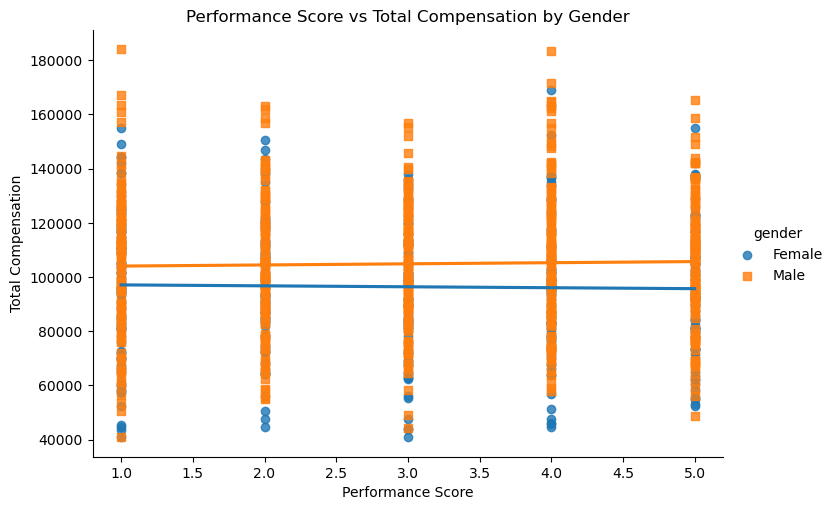

In [12]:
# Create a scatter plot with regression lines for each gender
sns.lmplot(
    x='perfeval', 
    y='total_compensation', 
    hue='gender', 
    data=df, 
    aspect=1.5, 
    markers=['o', 's'], 
    ci=None
)

# Add labels and title
plt.xlabel('Performance Score')
plt.ylabel('Total Compensation')
plt.title('Performance Score vs Total Compensation by Gender')
plt.show()

The graph generated above is a scatter plot with regression lines for each gender, visualizing the relationship between performance evaluation scores (`perfeval`) and total compensation (`total_compensation`). Here's an explanation:

1. **Scatter Points**: Each point represents an individual employee, with their performance evaluation score on the x-axis and their total compensation on the y-axis. The points are color-coded by gender (e.g., blue for males and orange for females).

2. **Regression Lines**: Separate regression lines are fitted for male and female employees. These lines show the trend or relationship between performance scores and total compensation for each gender.

3. **Comparison**: By comparing the slopes and positions of the regression lines, we can assess whether the relationship between performance scores and compensation differs by gender. For example:
    - If the slopes differ, it suggests that performance scores have a different impact on compensation for males and females.
    - If the lines are parallel but offset, it indicates a consistent difference in compensation between genders, regardless of performance.

4. **Insights**: This visualization helps identify potential disparities in how performance evaluation scores translate into compensation for male and female employees, providing a basis for further statistical analysis or policy review.